In [103]:
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
import torchvision
import random
import torch
import os

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
img_size = (256,256)
transformations = v2.Compose([
    #v2.ToImage(),
    v2.Resize(img_size),
    v2.RandomApply([
        v2.RandomRotation(degrees=(0, 20)),
        v2.RandomHorizontalFlip(p=1),
        v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.3, 0.3)),
    ], p=0.7),
    v2.RGB(),
    #v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor(),
])

dataset = datasets.ImageFolder('./Dataset', transform=transformations)

train, test = random_split(dataset, [0.8, 0.2])

trainloader = DataLoader(train, batch_size=64, shuffle=True)
testloader = DataLoader(test, batch_size=64, shuffle=False)

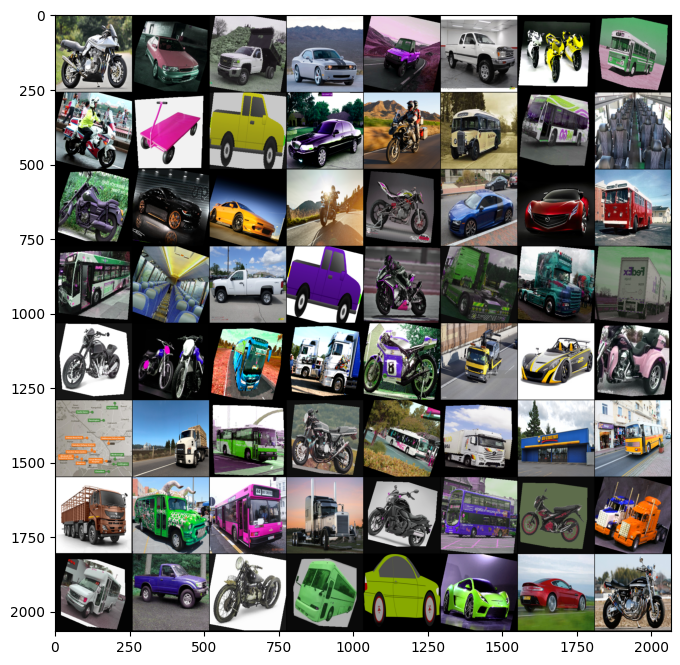

In [106]:
def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))

In [107]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loader)

def train(model, trainloader, testloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch + 1} | Training Loss: {running_loss / len(trainloader):.4f} | Validation Loss: {val_loss:.4f}')
            

In [108]:
resnet = torchvision.models.resnet152(weights = torchvision.models.ResNet152_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(2048, 4)

for name, params in resnet.named_parameters():
    if name not in ('fc.weight', 'fc.bias'):
        params.requires_grad = False

In [109]:
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
epochs = 10

In [110]:
train(resnet, trainloader, testloader, optimizer, criterion, epochs)

100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch: 1 | Training Loss: 1.3086 | Validation Loss: 1.1368


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Epoch: 2 | Training Loss: 1.0356 | Validation Loss: 0.8969


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Epoch: 3 | Training Loss: 0.8361 | Validation Loss: 0.7336


100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


Epoch: 4 | Training Loss: 0.7002 | Validation Loss: 0.5814


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Epoch: 5 | Training Loss: 0.5611 | Validation Loss: 0.5716


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Epoch: 6 | Training Loss: 0.5055 | Validation Loss: 0.4549


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch: 7 | Training Loss: 0.4534 | Validation Loss: 0.4274


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch: 8 | Training Loss: 0.3702 | Validation Loss: 0.3724


100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch: 9 | Training Loss: 0.3632 | Validation Loss: 0.3487


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Epoch: 10 | Training Loss: 0.3182 | Validation Loss: 0.3092


In [111]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return (corrected / total) * 100

def confusion_matrix(model, loader):
    model.eval()
    num_classes = 4
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for true, pred in zip(labels, predicted):
                confusion_matrix[true.item(), pred.item()] += 1

    confusion_matrix = confusion_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g',
                     xticklabels=['Bus', 'Car', 'Motorcycle', 'Truck'], yticklabels=['Bus', 'Car', 'Motorcycle', 'Truck'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()
    return ax

A rede atinge: 95.0% de acurácia


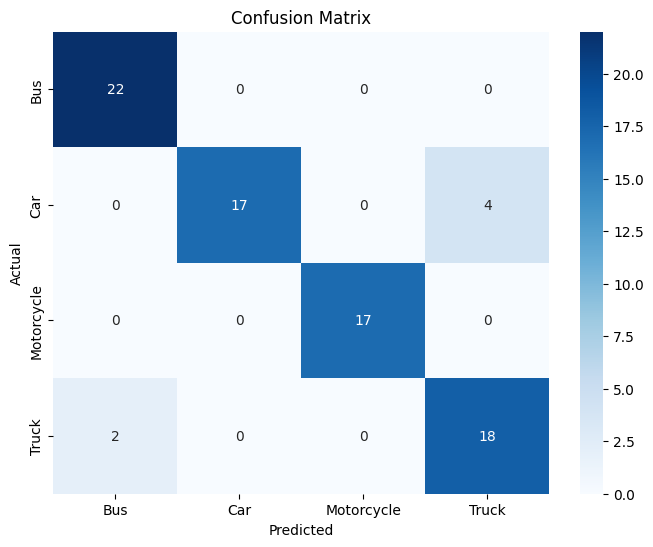

In [112]:
print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)

In [113]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return ['Bus', 'Car', 'Motorcycle', 'Truck'][result]

In [114]:
from PIL import Image

x = Image.open('img/bitrem.jpeg').convert('RGB')
x = transformations(x)

In [115]:
print(f'Resnet Prediction: {predict(resnet, x)}')

Resnet Prediction: Truck


In [117]:
# torch.save(resnet.state_dict(), './last-best-model.pth')

### Precisa fazer alguma pika pra carregar o modelo, e rodar ele junto com a bateria de validaçao do modelo atual, e salvar o que der melhor resultado